In [148]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors

ENERGY = 25 # GeV 

PARTICLE = "gamma"

root_dir = f"Sim_maps/Slices_{ENERGY}GeV_{PARTICLE}s"

NUM_EVENTS = len(os.listdir(root_dir))

NUM_BINS = 400

energy_deps = np.empty( (NUM_EVENTS, NUM_BINS), dtype=float )

z_array = np.arange(NUM_BINS) + 0.5 # in mm

for evn, filename in enumerate(os.listdir(root_dir)):

    path = os.path.join(root_dir,filename)

    with open(path) as file:

        file.readline() # skip first lines in the header
        file.readline()
        file.readline()

        for bin_n, line in enumerate(file):

            eDep_slice = float(line.split(",")[3])

            energy_deps[evn, bin_n] = eDep_slice

## 4X0 vs 25X0 correlations

In [149]:
def draw_4X0_24X0_correlations(ax, e_deps):


    eDep_4X  = np.sum(e_deps[:,:64], axis = 1)
    eDep_25X = np.sum(e_deps,        axis = 1)
    

    print(np.nonzero(eDep_25X >= ENERGY*1000))

    eDep_ratio = eDep_4X/eDep_25X

    corrcoef = np.corrcoef(eDep_25X, eDep_ratio)[1,0]

    _, _, _, img = ax.hist2d(eDep_25X, eDep_ratio, bins=[25, 25], norm=colors.LogNorm(vmin=0.05))

    ax.text(0.05, 0.95, "Correlation coef. = {:.3f}".format(corrcoef), transform=ax.transAxes, color="red")

    return img

(array([], dtype=int64),)


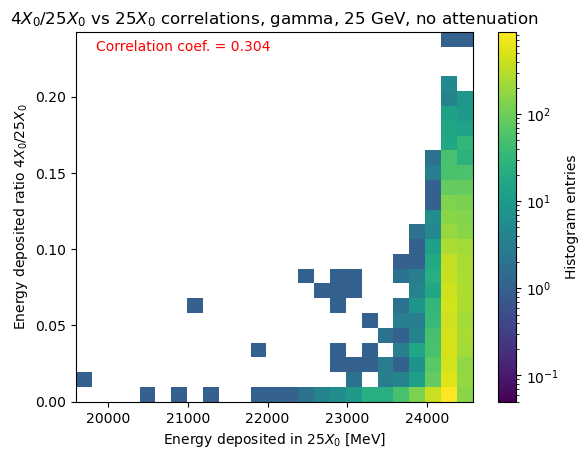

In [150]:
fig, ax = plt.subplots()

img = draw_4X0_24X0_correlations(ax, energy_deps)

ax.set_xlabel("Energy deposited in $25X_0$ [MeV]")
ax.set_ylabel("Energy deposited ratio $4X_0/25X_0$")
ax.set_title(f"$4X_0/25X_0$ vs $25X_0$ correlations, {PARTICLE}, {ENERGY} GeV, no attenuation")

cbar = fig.colorbar(img, ax=ax)
cbar.ax.set_ylabel("Histogram entries")

fig.savefig(f"Pictured_results/$4X_0|25X_0$ vs $25X_0$ correlations, {PARTICLE}, {ENERGY} GeV, no attenuation.png")

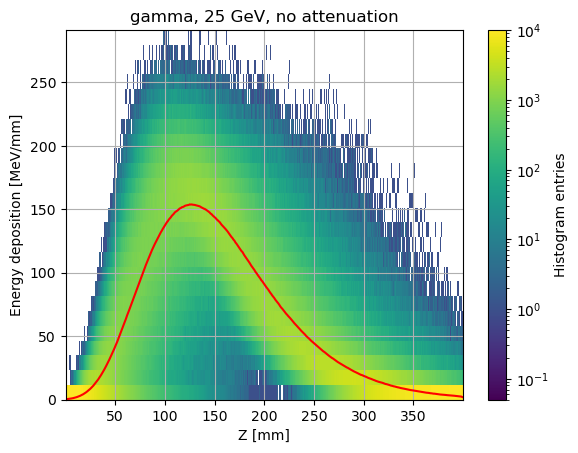

In [151]:
plt.figure()
plt.hist2d(np.tile(z_array, NUM_EVENTS), energy_deps.flatten(), bins=[NUM_BINS, 25], norm=colors.LogNorm(vmin=0.05))
plt.xlabel("Z [mm]")
plt.ylabel("Energy deposition [MeV/mm]")
plt.title(f"{PARTICLE}, {ENERGY} GeV, event vise distrubutin of energy along Z axis")

cbar = plt.colorbar()
cbar.ax.set_ylabel("Histogram entries")


# plt.figure()
plt.plot(np.mean(energy_deps, axis=0), "red")

plt.xlabel("Z [mm]")
plt.ylabel("Energy deposition [MeV/mm]")
plt.title(f"{PARTICLE}, {ENERGY} GeV, no attenuation")

# plt.text(0.5, 0.8, f"{ENERGY} GeV gammas\naveraged over {NUM_EVENTS} events", transform=plt.gca().transAxes)
plt.grid()

plt.savefig(f"Pictured_results/{PARTICLE}, {ENERGY} GeV, event vise distrubutin of energy along Z axis.png")

In [152]:
from scipy.optimize import curve_fit 

def dispHistAndGauss(ax, data):

    n_bins = int(np.sqrt(data.size))
    bin_size = (np.max(data) - np.min(data))/n_bins

    histCounts, edges, _ = ax.hist(data, bins = n_bins)
    binCenters = (edges[1:] + edges[:-1])/2

    gaussFunc = lambda x, A, mu, sig: A*np.exp(-(x-mu)**2/sig**2/2)
    mu = np.mean(data)
    sig = np.std(data, ddof=1)
    A = data.size/(np.sqrt(2*np.pi)*sig)*bin_size
    p0 = (A, mu, sig)

    (A, mu, sig), _ = curve_fit(gaussFunc, binCenters, histCounts , p0=p0)

    x_gauss = np.linspace(np.min(data), np.max(data), 4*n_bins)
    y_gauss = gaussFunc(x_gauss, A, mu, sig)

    ax.plot(x_gauss, y_gauss, "r", label="$\sigma={:.2e}$\n$\mu={:.2e}$\n$\sigma/\mu={:.2e}$".format(sig, mu, sig/mu))

    liml, limr = ax.get_xlim()
    ax.set_xlim(max(liml, mu-5*sig), min(limr, mu+5*sig))

    ax.legend()

## Average Z for each event ( Z weighted by E(Z) )

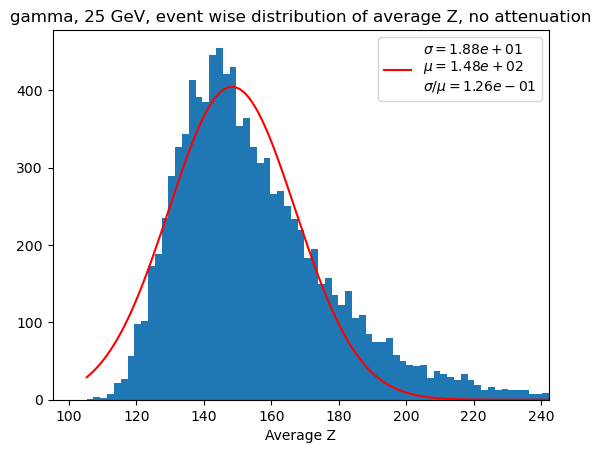

In [153]:
average_Z = np.sum(energy_deps * z_array, axis = 1 ) / np.sum(energy_deps, axis = 1 )

plt.figure()
ax = plt.gca()

dispHistAndGauss(ax, average_Z)

plt.xlabel("Average Z")
plt.title(f"{PARTICLE}, {ENERGY} GeV, event wise distribution of average Z, no attenuation")

plt.savefig(f"Pictured_results/{PARTICLE}, {ENERGY} GeV, event wise distribution of average Z, no attenuation.png")

## Functions

In [154]:
def draw_Ez_dep_weighted(ax, aten_W):

    eDep_aver = np.mean(energy_deps, axis=0)
    # eDep_aver /= np.max(eDep_aver)

    eDep_aver_w = np.mean(energy_deps, axis=0)*aten_W
    # eDep_aver_w /= np.max(eDep_aver_w)

    ln1 = ax.plot(z_array, eDep_aver, label="Deposition (not weighted)")
    ln2 = ax.plot(z_array, eDep_aver_w, label="Deposition (weighted)")

    ax.set_xlabel("Z [mm]")
    ax.set_ylabel("Energy deposition [MeV/mm]")

    ax.grid()

    axr = ax.twinx()

    ln3 = axr.plot(z_array, aten_W, "r", label="Attenuation weight")
    axr.set_ylim(0, None)
    axr.set_ylabel("Attenuation weight")


    # show_legends
    lns = ln3+ln1+ln2
    labs = [l.get_label() for l in lns]
    ax.legend(lns, labs, loc="lower center")



def draw_Edep_hist_weighted(ax, aten_W):

    eDep_eff = np.sum(energy_deps*aten_W, axis=1)


    dispHistAndGauss(ax, eDep_eff)

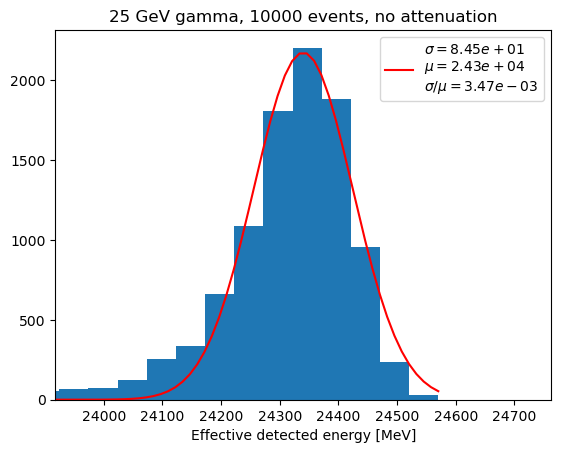

In [155]:
fig2, ax2 = plt.subplots()
draw_Edep_hist_weighted(ax2, np.ones_like(z_array))
ax2.set_title(f"{ENERGY} GeV {PARTICLE}, {NUM_EVENTS} events, no attenuation")
ax2.set_xlabel("Effective detected energy [MeV]")
fig2.savefig(f"{ENERGY} GeV {PARTICLE}, {NUM_EVENTS} events, no attenuation.png")

## O2 fiber, no mirrors

(array([ 151,  440,  623,  824,  901, 1046, 1070, 1100, 1123, 1245, 1323,
       1373, 1498, 1551, 1772, 1775, 2021, 2057, 2075, 2184, 2299, 2474,
       2686, 2781, 2880, 3293, 3308, 3580, 3582, 3723, 3894, 3918, 3966,
       3995, 4151, 4854, 5315, 5751, 5798, 5872, 5993, 6045, 6066, 6122,
       6229, 6463, 6835, 7127, 7199, 7488, 7550, 7709, 7848, 8178, 8377,
       8538, 8630, 8880, 9005, 9076, 9133, 9151, 9329, 9408, 9604, 9786]),)


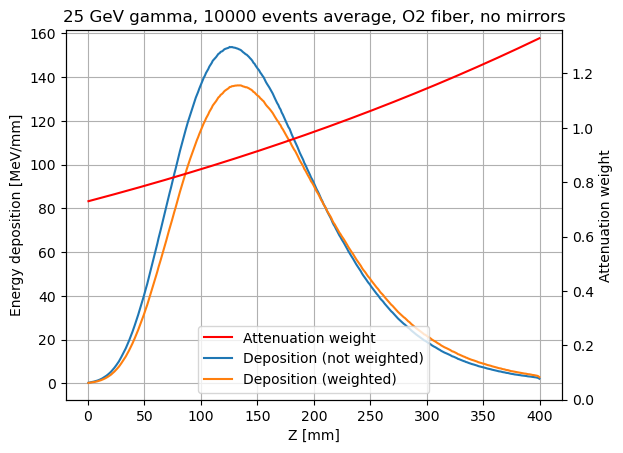

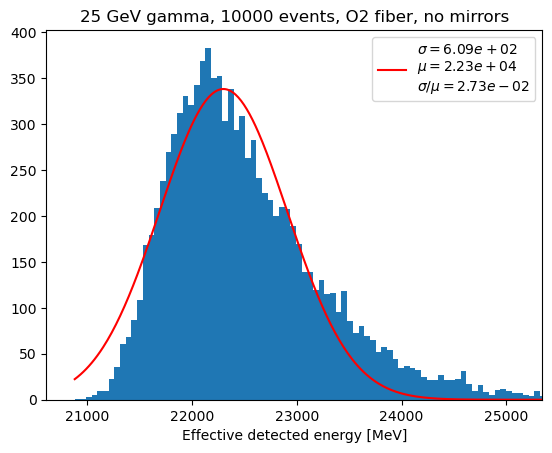

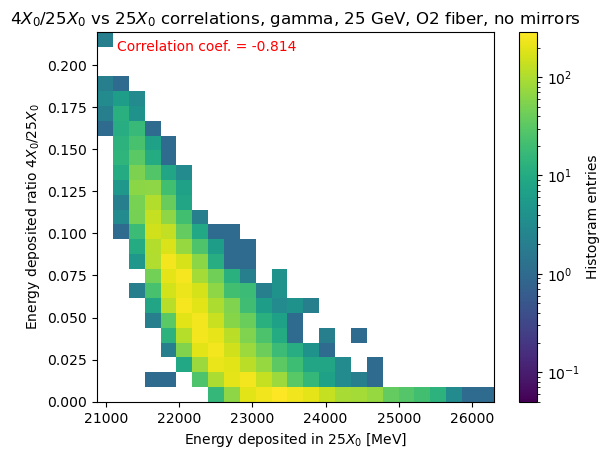

In [156]:
aten_W_O2 = np.exp(-((500-z_array)/665.9))
aten_W_O2 /= np.mean(aten_W_O2)

fig1, ax1 = plt.subplots()
draw_Ez_dep_weighted(ax1, aten_W_O2)
ax1.set_title(f"{ENERGY} GeV {PARTICLE}, {NUM_EVENTS} events average, O2 fiber, no mirrors")
fig1.savefig(f"Pictured_results/{ENERGY} GeV {PARTICLE}, {NUM_EVENTS} events average, O2 fiber, no mirrors.png")

fig2, ax2 = plt.subplots()
draw_Edep_hist_weighted(ax2, aten_W_O2)
ax2.set_title(f"{ENERGY} GeV {PARTICLE}, {NUM_EVENTS} events, O2 fiber, no mirrors")
ax2.set_xlabel("Effective detected energy [MeV]")
fig2.savefig(f"Pictured_results/{ENERGY} GeV {PARTICLE}, {NUM_EVENTS} events, O2 fiber, no mirrors.png")

fig3, ax3 = plt.subplots()
img = draw_4X0_24X0_correlations(ax3, energy_deps*aten_W_O2)

ax3.set_xlabel("Energy deposited in $25X_0$ [MeV]")
ax3.set_ylabel("Energy deposited ratio $4X_0/25X_0$")
ax3.set_title(f"$4X_0/25X_0$ vs $25X_0$ correlations, {PARTICLE}, {ENERGY} GeV, O2 fiber, no mirrors")

cbar = fig.colorbar(img, ax=ax3)
cbar.ax.set_ylabel("Histogram entries")
fig3.savefig(f"Pictured_results/$4X_0|25X_0$ vs $25X_0$ correlations, {PARTICLE}, {ENERGY} GeV, O2 fiber, no mirrors.png")


## Y11 fiber, no mirrors

(array([], dtype=int64),)


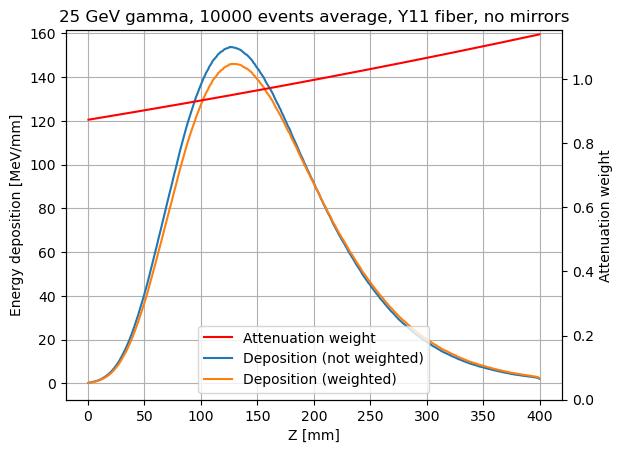

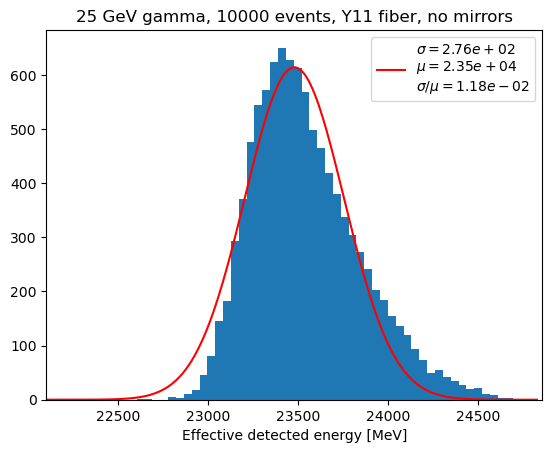

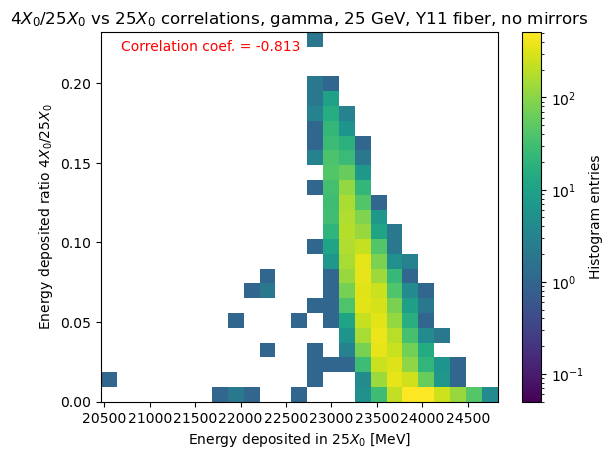

In [157]:
aten_W_Y11 = np.exp(-((500-z_array)/1500))
aten_W_Y11 /= np.mean(aten_W_Y11)


fig1, ax1 = plt.subplots()
draw_Ez_dep_weighted(ax1, aten_W_Y11)
ax1.set_title(f"{ENERGY} GeV {PARTICLE}, {NUM_EVENTS} events average, Y11 fiber, no mirrors")
fig1.savefig(f"Pictured_results/{ENERGY} GeV {PARTICLE}, {NUM_EVENTS} events average, Y11 fiber, no mirrors.png")

fig2, ax2 = plt.subplots()
draw_Edep_hist_weighted(ax2, aten_W_Y11)
ax2.set_title(f"{ENERGY} GeV {PARTICLE}, {NUM_EVENTS} events, Y11 fiber, no mirrors")
ax2.set_xlabel("Effective detected energy [MeV]")
fig2.savefig(f"Pictured_results/{ENERGY} GeV {PARTICLE}, {NUM_EVENTS} events, Y11 fiber, no mirrors.png")

fig3, ax3 = plt.subplots()
img = draw_4X0_24X0_correlations(ax3, energy_deps*aten_W_Y11)

ax3.set_xlabel("Energy deposited in $25X_0$ [MeV]")
ax3.set_ylabel("Energy deposited ratio $4X_0/25X_0$")
ax3.set_title(f"$4X_0/25X_0$ vs $25X_0$ correlations, {PARTICLE}, {ENERGY} GeV, Y11 fiber, no mirrors")

cbar = fig.colorbar(img, ax=ax3)
cbar.ax.set_ylabel("Histogram entries")
fig3.savefig(f"Pictured_results/$4X_0|25X_0$ vs $25X_0$ correlations, {PARTICLE}, {ENERGY} GeV, Y11 fiber, no mirrors.png")


## O2 fiber, with mirrors

(array([], dtype=int64),)


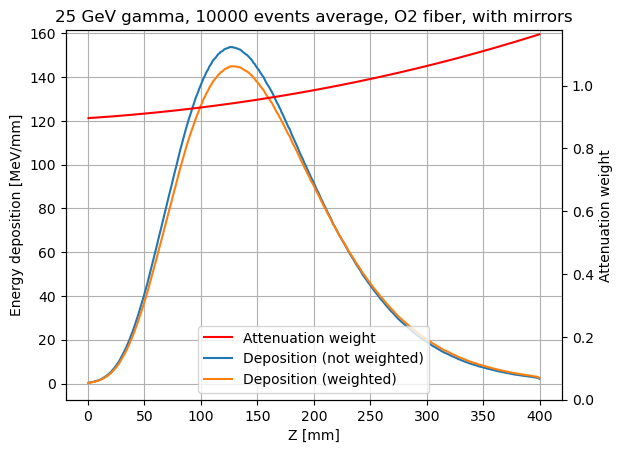

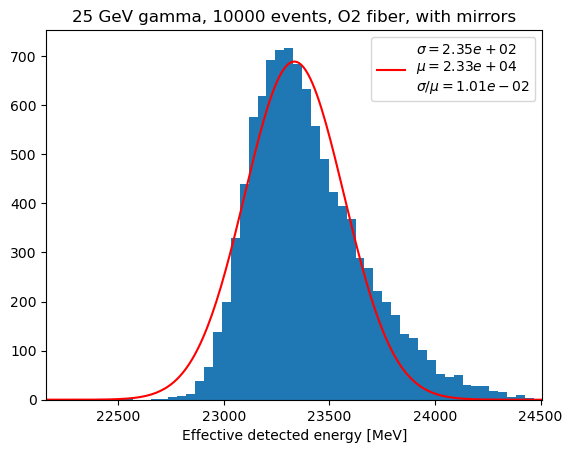

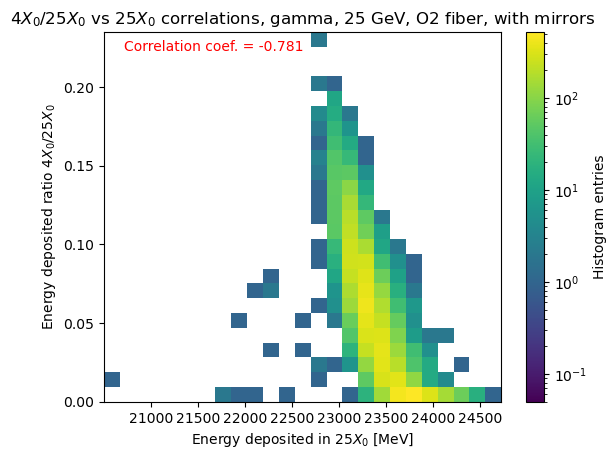

In [158]:
aten_W_mirror_O2 = np.exp(-((500-z_array)/665.9)) + 0.7 * np.exp(-((500 +z_array)/665.9))
aten_W_mirror_O2 /= np.mean(aten_W_mirror_O2)

fig1, ax1 = plt.subplots()
draw_Ez_dep_weighted(ax1, aten_W_mirror_O2)
ax1.set_title(f"{ENERGY} GeV {PARTICLE}, {NUM_EVENTS} events average, O2 fiber, with mirrors")
fig1.savefig(f"Pictured_results/{ENERGY} GeV {PARTICLE}, {NUM_EVENTS} events average, O2 fiber, with mirrors.png")

fig2, ax2 = plt.subplots()
draw_Edep_hist_weighted(ax2, aten_W_mirror_O2)
ax2.set_title(f"{ENERGY} GeV {PARTICLE}, {NUM_EVENTS} events, O2 fiber, with mirrors")
ax2.set_xlabel("Effective detected energy [MeV]")
fig2.savefig(f"Pictured_results/{ENERGY} GeV {PARTICLE}, {NUM_EVENTS} events, O2 fiber, with mirrors.png")

fig3, ax3 = plt.subplots()
img = draw_4X0_24X0_correlations(ax3, energy_deps*aten_W_mirror_O2)

ax3.set_xlabel("Energy deposited in $25X_0$ [MeV]")
ax3.set_ylabel("Energy deposited ratio $4X_0/25X_0$")
ax3.set_title(f"$4X_0/25X_0$ vs $25X_0$ correlations, {PARTICLE}, {ENERGY} GeV, O2 fiber, with mirrors")

cbar = fig.colorbar(img, ax=ax3)
cbar.ax.set_ylabel("Histogram entries")
fig3.savefig(f"Pictured_results/$4X_0|25X_0$ vs $25X_0$ correlations, {PARTICLE}, {ENERGY} GeV, O2 fiber, with mirrors.png")

## Y11 fiber, with mirrors

(array([], dtype=int64),)


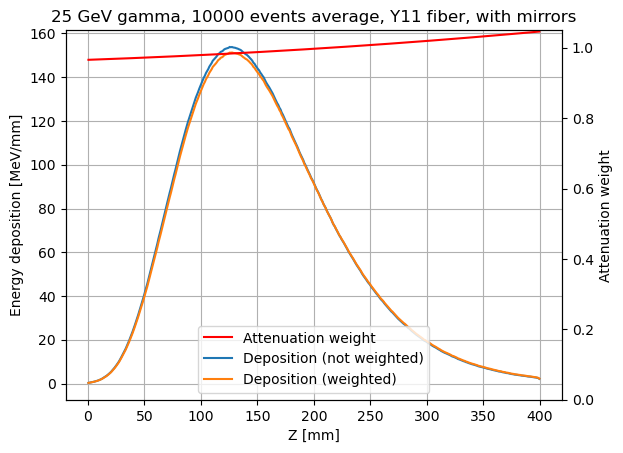

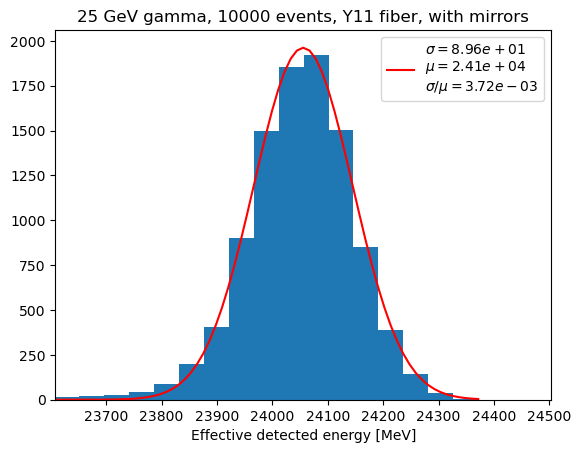

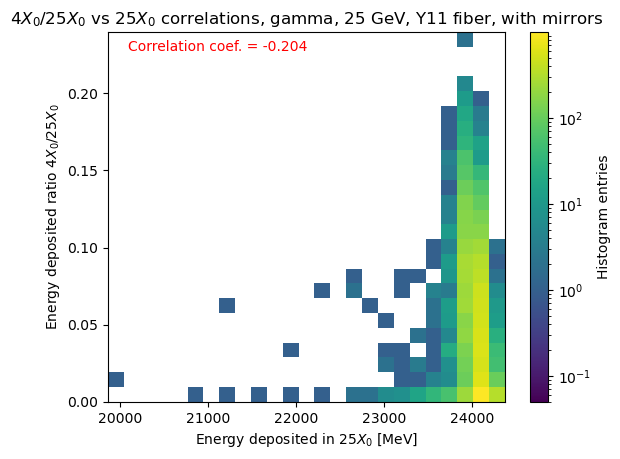

In [159]:
aten_W_mirror_Y11 = np.exp(-((500-z_array)/1500)) + 0.7 * np.exp(-((500 +z_array)/1500))
aten_W_mirror_Y11 /= np.mean(aten_W_mirror_Y11)


fig1, ax1 = plt.subplots()
draw_Ez_dep_weighted(ax1, aten_W_mirror_Y11)
ax1.set_title(f"{ENERGY} GeV {PARTICLE}, {NUM_EVENTS} events average, Y11 fiber, with mirrors")
fig1.savefig(f"Pictured_results/{ENERGY} GeV {PARTICLE}, {NUM_EVENTS} events average, Y11 fiber, with mirrors.png")

fig2, ax2 = plt.subplots()
draw_Edep_hist_weighted(ax2, aten_W_mirror_Y11)
ax2.set_title(f"{ENERGY} GeV {PARTICLE}, {NUM_EVENTS} events, Y11 fiber, with mirrors")
ax2.set_xlabel("Effective detected energy [MeV]")
fig2.savefig(f"Pictured_results/{ENERGY} GeV {PARTICLE}, {NUM_EVENTS} events, Y11 fiber, with mirrors.png")

fig3, ax3 = plt.subplots()
img = draw_4X0_24X0_correlations(ax3, energy_deps*aten_W_mirror_Y11)

ax3.set_xlabel("Energy deposited in $25X_0$ [MeV]")
ax3.set_ylabel("Energy deposited ratio $4X_0/25X_0$")
ax3.set_title(f"$4X_0/25X_0$ vs $25X_0$ correlations, {PARTICLE}, {ENERGY} GeV, Y11 fiber, with mirrors")


cbar = fig3.colorbar(img, ax=ax3)
cbar.ax.set_ylabel("Histogram entries")
fig3.savefig(f"Pictured_results/$4X_0|25X_0$ vs $25X_0$ correlations, {PARTICLE}, {ENERGY} GeV, Y11 fiber, with mirrors.png")
